<a href="https://colab.research.google.com/github/Ron-Wu/Machine-learning-0602/blob/main/transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
"""
建議可將圖片集生成壓縮檔再上傳google drive，
之後再colab再使用 zipfile 功能來解壓縮，
生成在colab的虛擬電腦中 
"""
import zipfile
fn = "/content/drive/MyDrive/additional/train.zip"
zf = zipfile.ZipFile(fn)
zf.extractall()

In [ ]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
fns = glob.glob("train/*")
print(len(fns))
img = Image.open(fns[0])
print(img.size)
plt.imshow(img)

# import glob
# fns = glob.glob("train/*")
# print(len(fns))
# fns[0]

# from PIL import Image
# img = Image.open(fns[0])

# import matplotlib.pyplot as plt
# print(img.size) # 也可以轉成使用np.array 來看 .shape
# plt.imshow(img)

In [ ]:
"""
因為每張圖片太大，如果直接讀圖RAM會炸掉，
所以先把資料轉成序列
"""
import pandas as pd
dogf =  glob.glob("train/dog.*")
catf =  glob.glob("train/cat.*")
data = pd.DataFrame({
  "path":dogf + catf,
  "target":[0] * len(dogf) + [1] * len(catf) # 做出 12500 個 0 的list和 12500 個 1 的list
})
data

In [ ]:
"""
%tensorflow_version 1.x # 如果有需要從tensorflow 1 的keras函數時可以這樣載入
"""

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
t1 = GlobalAveragePooling2D()(vgg.output)
out = Dense(2, activation="softmax")(t1)
model = Model(inputs=vgg.input, outputs=out)
model.summary()

# from tensorflow.keras.applications.vgg16 import VGG16
# vgg = VGG16(include_top=False,input_shape=(224, 224, 3))

# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
# # 如果用model一定要將tensor一層傳一層才可以串接在一起
# t1 = GlobalAveragePooling2D()(vgg.output)
# out = Dense(2, activation="softmax")(t1)
# model = Model(inputs=vgg.input, outputs=out)
# model.summary()

In [ ]:
# 如果用sequential則不一定要將tensor一層傳一層才可以串接在一起

from tensorflow.keras.layers import BatchNormalization
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
# trainable設定一定要在compile之前
for l in vgg.layers:
    l.trainable = False
layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
model = Sequential(vgg.layers + layers)
model.summary()

In [11]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer=Adam(),
              metrics=["accuracy"])

In [12]:
# test = np.random.randint(0, 255, size=(3, 32, 32, 3)) # low=0, high=255
# # np.array[第一個軸我要哪幾個, 第二個軸我要哪幾個....]
# print(test.shape)
# print(test[0:2].shape)
# print(test[0:2,0:28,0:28,0:2].shape)
# print(test[:,:,:,0:2].shape)
# print(test[...,0:2].shape)

In [ ]:
"""
一張照片如何做處理
"""
import numpy as np
# 圖片如何處理: 不是除255.0, 請always使用你偷來的模型同樣處理方式
from tensorflow.keras.applications.vgg16 import preprocess_input
img = Image.open(fns[0]).convert("RGB").resize((224, 224))
img_np = np.array(img)
preprocess_input(img_np)

# import numpy as np
# # 圖片如何處理: 不是除255.0, 請always使用你偷來的模型同樣處理方式
# from tensorflow.keras.applications.vgg16 import preprocess_input

# """
# Image.open(fns[0]) = 先開啟第一張圖片，
# convert("RGB") = 把類別轉成RGB格式，
# resize((224, 224)) = 調整圖片大小以符合VGG16的模型，resize內必須是個tuple形式
# """
# img = Image.open(fns[0]).convert("RGB").resize((224, 224))

# # 將圖片轉成np.array
# img_np = np.array(img)
# # 將其套用到被遷移的模型預處理的preprocess_input
# preprocess_input(img_np)

In [14]:
"""
一堆照片如何做處理，設計一個函式，套用進去
"""
# 我們無法使用fit, 1. fit_generator 2.train_on_batch/test_on_batch
# random.randint(0, 2(inclusive)): 0,1,2 是包含2的
# np.random,randint(0, 3(exclusive)): 0,1,2 沒有包含3
def get_data(x, y, batch=20):
    idx = np.random.randint(0, len(x), size=batch)
    xidx, yidx = x[idx], y[idx]
    img_ori, img_pre, ans = [], [], []
    for xi, yi in zip(xidx, yidx):
        img = Image.open(xi).convert("RGB").resize((224, 224))
        img_np = np.array(img)
        img_p = preprocess_input(img_np)
        img_ori.append(img_np)
        img_pre.append(img_p)
        ans.append(yi)
    return np.array(img_ori), np.array(img_pre), np.array(ans)

In [ ]:
from sklearn.model_selection import train_test_split
x, y = np.array(data["path"]), np.array(data["target"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
# batch = 25000
img_ori, img_pre, ans = get_data(x_train, y_train)
print(img_ori.shape)
print(img_pre.shape)
print(ans.shape)

In [ ]:
for i in range(100):
    print("-" * 15, i, "-" * 15)
    img_ori, img_p, ans = get_data(x_train, y_train)
    result = model.train_on_batch(img_p, ans)
    print("train:", result)
    img_ori, img_p, ans = get_data(x_test, y_test)
    result = model.test_on_batch(img_p, ans)
    print("validate:", result)

In [17]:
# 1. 發覺loss跳動幅度太高
# 2. 發覺預測機率1.0 * e+0
# 沒有把輸入調整到合理範圍(norm)
img_ori, img_p, ans = get_data(x_test, y_test, batch=200)
pre = model.predict(img_p)
# Model沒有predict_classes可以用, 以後好像也要移除predict_classes
classes = pre.argmax(axis=1)
model.evaluate(img_p, ans)

7/7 [==============================] - 1s 121ms/step - loss: 0.1142 - accuracy: 0.9750


[0.11416517943143845, 0.9750000238418579]

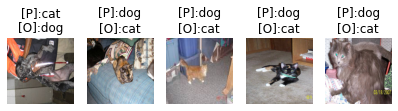

In [18]:
import numpy as np
names = ["dog", "cat"]
idx = np.nonzero(classes != ans)[0]
# np.nonzero([[0, 2, 0], [0, 0, 3]])
false_pre = classes[idx]
false_label = ans[idx] 
false_img = img_ori[idx]

plt.figure(figsize=(14, 42))
width = 10
height = len(idx) // width + 1
for i in range(len(false_img)):
    plt.subplot(height, width, i+1)
    title = "[P]:{}\n[O]:{}".format(names[false_pre[i]], names[false_label[i]])
    plt.title(title)
    plt.axis("off")
    plt.imshow(false_img[i])

In [ ]:
import requests
from PIL import Image
url = input("輸入網址:")
response = requests.get(url, verify=False, stream=True)
img = Image.open(response.raw)
img = img.resize((224, 224)).convert("RGB")
img_np = np.array(img).reshape(1, 224, 224, 3)
img_norm = preprocess_input(img_np)
pre = model.predict(img_norm)[0]
for n, p in zip(names, pre):
    print(n, "的機率:", round(p, 3))
plt.imshow(img)